In [1]:
spatialSample="p16" #p16 or spider. Key.

In [2]:
#Detect GPU.

import subprocess
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception:
    print('No Nvidia GPU detected!')

Nvidia GPU detected!


In [3]:
#Detect GPU.

import torch
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached: ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
else:
    print("GPU is not available")
    device = torch.device("cpu")

#FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`.

GPU is available
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:  0.0 GB


/tmp/ipykernel_2837456/4139710248.py:10: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached: ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


In [4]:
import scanpy as sc
import numpy as np
import cell2location

#This takes a few minutes.

#SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
#SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [5]:
results_folder=f"/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_spatialCellTypes/1.5_resultCell2location/{spatialSample}/" #No need to create these folders in advance.

#Create paths to results folders for reference regression and cell2location models.
ref_run_name=f"{results_folder}/reference_signatures"
run_name=f"{results_folder}/cell2location_map"

In [6]:
adata_vis=sc.read_h5ad(f"/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_prepareData/_Data/dataSpatial_{spatialSample}.h5ad")
adata_ref=sc.read_h5ad("/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_prepareData/_Data/dataSnRNASeq.h5ad")

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


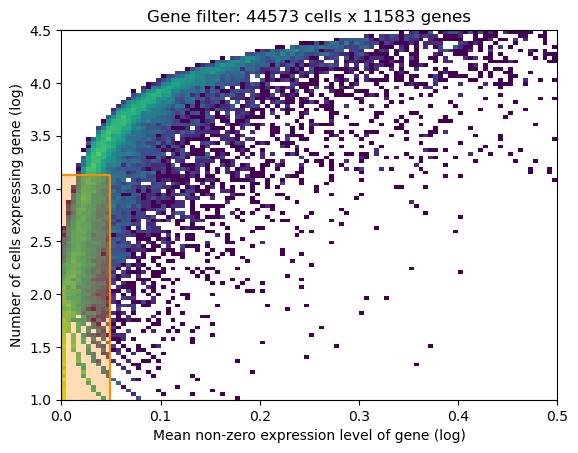

In [7]:
#Perform gene selection.
from cell2location.utils.filtering import filter_genes
selected=filter_genes(adata_ref,
                      cell_count_cutoff=5,cell_percentage_cutoff2=0.03,nonz_mean_cutoff=1.12) #11,583 genes selected.

#RuntimeWarning: divide by zero encountered in log10.

In [8]:
#Filter the object.
adata_ref=adata_ref[:,selected].copy()

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 44573 × 11583
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'celltype'
    var: 'names', 'n_cells', 'nonz_mean'

In [10]:
#Cast sparse matrix as CSR.
from scipy.sparse import csr_matrix
adata_ref.X=csr_matrix(adata_ref.X)

#Estimate reference cell type signatures (NB regression).
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                                                   batch_key="sample", #10X reaction/sample/batch.
                                                   labels_key="celltype" #Cell type, covariate used for constructing signatures.
                                                  )

#If I don't cast sparse matrix as CSR:
#UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.

In [11]:
adata_ref

AnnData object with n_obs × n_vars = 44573 × 11583
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'celltype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'names', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [12]:
adata_ref.obs

,nCount_RNA,nFeature_RNA,percent.mt,sample,celltype,_indices,_scvi_batch,_scvi_labels
AAACAGCCAAACATAG-1,2972.0,1738,2.254374,SN3_1,Fibroblasts,0,2,4
AAACAGCCAACTAGAA-4,3373.0,1812,0.859769,MI_4,Endothelial cells,1,1,2
AAACAGCCAACTCGCG-1,1410.0,1006,0.141844,SN3_1,Immune-T cells,2,2,6
AAACAGCCAAGGTATA-2,3021.0,2049,0.264813,SN3_2,Endothelial cells,3,3,2
AAACAGCCAAGGTCGA-2,2670.0,1740,0.411985,SN3_2,Fibroblasts,4,3,4
...,...,...,...,...,...,...,...,...
TTTGTTGGTGTGCACG-3,2738.0,1297,1.533966,MI_1,Fibroblasts,44568,0,4
TTTGTTGGTTAATGAC-2,5044.0,2058,0.118953,SN3_2,Cardiomyocytes,44569,3,0
TTTGTTGGTTACTTCA-1,3772.0,2131,0.450689,SN3_1,Fibroblasts,44570,2,4
TTTGTTGGTTAGTACG-2,2082.0,1325,0.288184,SN3_2,Fibroblasts,44571,3,4


In [13]:
adata_ref.uns

OrderedDict([('_scvi_uuid', '8a2322ca-576f-4f20-91a1-4a6be4a22a72'),
             ('_scvi_manager_uuid', 'f2849f62-41f6-415b-b51d-4056771e9637')])

In [14]:
#Create the regression model.
from cell2location.models import RegressionModel
mod=RegressionModel(adata_ref)

In [15]:
#View anndata_setup as a sanity check.
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 44573 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │ 11583 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    MI_1    │          0          │
│                     │    MI_4    │          1          │
│                     │   SN3_1    │          2          │
│                     │   SN3_2    │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                        labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │   Cardiomyocytes    │          0          │
│                       │   Dentritic cells   │          1          │
│                       │  Endothelial cells  │          2          │
│                       │  Epicardial cells   │          3          │
│                       │     Fibroblasts     │          4          │
│                       │   Immune-B cells    │          5          │
│                       │   Immune-T cells    │          6          │
│                       │     Macrophages     │          7          │
│                       │      Pericytes      │          8          │
│                       │ Smooth muscle cells │          9          │
└───────────────────────┴─────────────────────┴─────────────────────┘

In [16]:
#Key step.
mod.train(max_epochs=250)

#This takes about 10 minutes.

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed 

Training:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


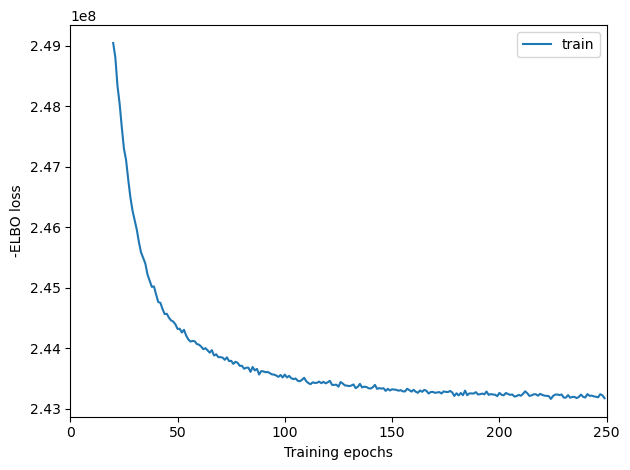

In [17]:
mod.plot_history(20) #Omit the first 20 epochs from the plot.

In [18]:
#Export the estimated cell abundance (summary of the posterior distribution).
adata_ref=mod.export_posterior(adata_ref,sample_kwargs={"num_samples":1000,"batch_size":2500})

#Save model.
mod.save(f"{ref_run_name}",overwrite=True)

#Save anndata object with results.
adata_file=f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...


Sampling local variables, batch:   0%|          | 0/18 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_spatialCellTypes/1.5_resultCell2location/p16//reference_signatures/sc.h5ad'

In [19]:
adata_ref

AnnData object with n_obs × n_vars = 44573 × 11583
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'celltype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'names', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'

In [20]:
adata_ref.varm["q05_per_cluster_mu_fg"]

,q05_per_cluster_mu_fg_Cardiomyocytes,q05_per_cluster_mu_fg_Dentritic cells,q05_per_cluster_mu_fg_Endothelial cells,q05_per_cluster_mu_fg_Epicardial cells,q05_per_cluster_mu_fg_Fibroblasts,q05_per_cluster_mu_fg_Immune-B cells,q05_per_cluster_mu_fg_Immune-T cells,q05_per_cluster_mu_fg_Macrophages,q05_per_cluster_mu_fg_Pericytes,q05_per_cluster_mu_fg_Smooth muscle cells
Xkr4,0.008967,0.158161,0.147544,1.084925,1.224998,0.074324,0.087840,0.125121,0.193438,0.361050
Gm19938,0.000188,0.000864,0.004338,0.035611,0.040981,0.004887,0.001197,0.004141,0.001847,0.009440
Sox17,0.000236,0.017617,0.209098,0.027204,0.003446,0.009443,0.010671,0.001568,0.015129,0.024060
Mrpl15,0.073755,0.060245,0.067072,0.089227,0.063183,0.027320,0.025574,0.051470,0.052779,0.044457
Lypla1,0.225188,0.190051,0.295420,0.363828,0.241001,0.183828,0.233629,0.214972,0.210752,0.229046
...,...,...,...,...,...,...,...,...,...,...
mt-Cytb,0.856717,2.032616,4.403598,8.192424,2.506329,1.035674,1.721523,1.763560,1.753060,4.670068
CAAA01118383.1,0.120569,0.175841,0.151196,0.281179,0.144791,0.114026,0.102752,0.169712,0.113162,0.168078
Vamp7,0.020996,0.024692,0.047789,0.079681,0.064854,0.036881,0.043725,0.043859,0.035365,0.033396
Tmlhe,0.311895,0.080160,0.347163,0.602287,0.404708,0.080113,0.247891,0.320895,0.320900,0.366735


In [21]:
np.sum(adata_ref.varm["q05_per_cluster_mu_fg"],axis=1)

Xkr4               3.466368
Gm19938            0.103493
Sox17              0.318473
Mrpl15             0.555081
Lypla1             2.387716
                    ...    
mt-Cytb           28.935568
CAAA01118383.1     1.541306
Vamp7              0.431239
Tmlhe              3.082747
AC149090.1         5.186886
Length: 11583, dtype: float32

In [22]:
np.sum(adata_ref.varm["q05_per_cluster_mu_fg"],axis=0)

q05_per_cluster_mu_fg_Cardiomyocytes         4138.259277
q05_per_cluster_mu_fg_Dentritic cells        2854.069824
q05_per_cluster_mu_fg_Endothelial cells      3002.679688
q05_per_cluster_mu_fg_Epicardial cells       4786.282227
q05_per_cluster_mu_fg_Fibroblasts            3295.928955
q05_per_cluster_mu_fg_Immune-B cells         1594.909180
q05_per_cluster_mu_fg_Immune-T cells         2037.565430
q05_per_cluster_mu_fg_Macrophages            2749.512207
q05_per_cluster_mu_fg_Pericytes              2723.875488
q05_per_cluster_mu_fg_Smooth muscle cells    3267.833496
dtype: float32

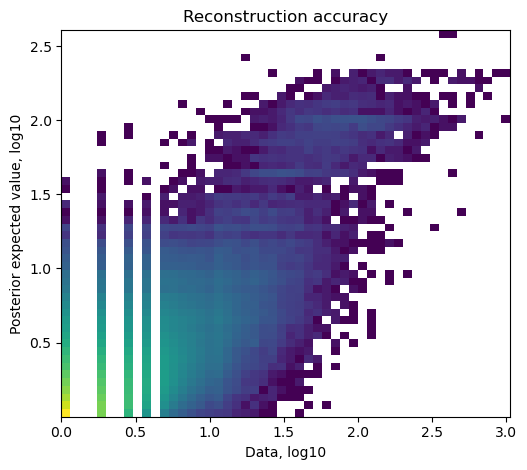

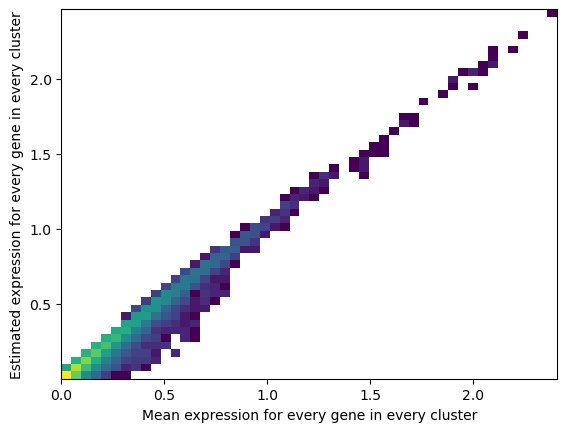

In [23]:
mod.plot_QC()

In [24]:
#Export estimated expression in each cluster.
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver=adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                                        for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver=adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                            for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns=adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5,0:5]

,Cardiomyocytes,Dentritic cells,Endothelial cells,Epicardial cells,Fibroblasts
Xkr4,0.013677,0.229317,0.160368,1.238635,1.293412
Gm19938,0.001120,0.006054,0.006156,0.049414,0.044739
Sox17,0.001198,0.035815,0.222166,0.039907,0.004549
Mrpl15,0.088022,0.092172,0.072897,0.111353,0.067068
Lypla1,0.246715,0.250503,0.309765,0.408658,0.250250


In [25]:
#Find shared genes and subset both anndata and reference signatures.
intersect=np.intersect1d(adata_vis.var_names,inf_aver.index)
adata_vis=adata_vis[:,intersect].copy()
inf_aver=inf_aver.loc[intersect,:].copy()

In [26]:
#Cast sparse matrix as CSR.
adata_vis.X=csr_matrix(adata_vis.X)

#Prepare anndata for cell2location model.
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)

#If I don't cast sparse matrix as CSR:
#UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.

In [27]:
#Create the model.
mod=cell2location.models.Cell2location(
    adata_vis,cell_state_df=inf_aver, #The expected average cell abundance: tissue-dependent.
    N_cells_per_location=10, #Hyper-prior which can be estimated from paired histology.
    detection_alpha=20 #Hyperparameter controlling normalisation of within-experiment variation in RNA detection.
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1808  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10376 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [28]:
#Train the model.
mod.train(max_epochs=30000,
          batch_size=None, #Train using full data. Use all data points in training because we need to estimate cell abundance at all locations.
          train_size=1
         )

#This takes about 30 minutes.

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed 

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30000` reached.


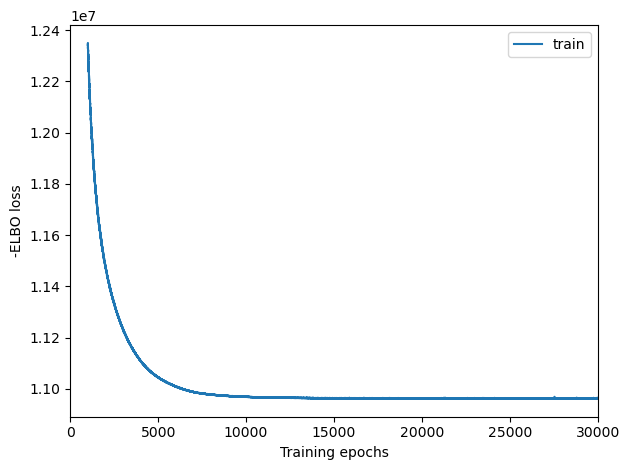

In [29]:
mod.plot_history(1000) #Omit the first 1000 epochs from the plot.

In [30]:
#Export the estimated cell abundance (summary of the posterior distribution).
adata_vis=mod.export_posterior(adata_vis,sample_kwargs={"num_samples":1000,"batch_size":mod.adata.n_obs})

#Save model.
mod.save(f"{run_name}",overwrite=True)

#Save anndata object with results.
adata_file=f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...


Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_spatialCellTypes/1.5_resultCell2location/p16//cell2location_map/sp.h5ad'

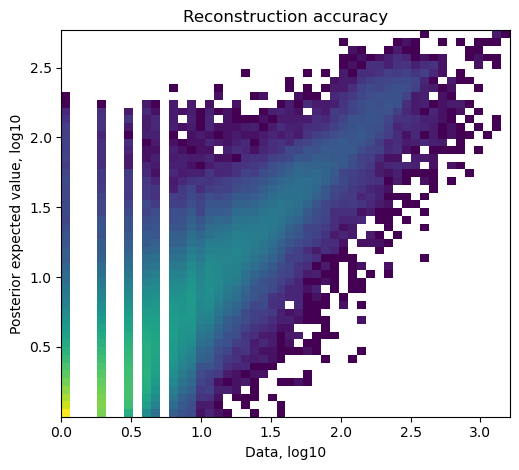

In [31]:
mod.plot_QC()

In [32]:
adata_vis

AnnData object with n_obs × n_vars = 1808 × 10376
    obs: 'nCount_Spatial', 'nFeature_Spatial', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'names'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

In [33]:
adata_vis.obsm["q05_cell_abundance_w_sf"] #We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka ‘at least this amount is present’).

,q05cell_abundance_w_sf_Cardiomyocytes,q05cell_abundance_w_sf_Dentritic cells,q05cell_abundance_w_sf_Endothelial cells,q05cell_abundance_w_sf_Epicardial cells,q05cell_abundance_w_sf_Fibroblasts,q05cell_abundance_w_sf_Immune-B cells,q05cell_abundance_w_sf_Immune-T cells,q05cell_abundance_w_sf_Macrophages,q05cell_abundance_w_sf_Pericytes,q05cell_abundance_w_sf_Smooth muscle cells
AACACGTTGATACCGC-1,11.804485,0.003052,1.751778,0.006607,0.023550,0.007045,0.015118,0.003162,0.160844,0.237903
AACAGGCCATTGTCAC-1,11.629239,0.000646,1.696997,0.000828,0.000630,0.123039,0.004598,0.003885,0.020175,0.001095
AACAGTATCCGCCTGG-1,13.244799,0.108678,3.339324,0.554798,2.893918,0.037238,0.013854,0.127368,0.272349,0.018408
AACATACTCCACAGTT-1,17.531912,0.002800,2.281082,0.000995,0.000673,0.005907,0.007006,0.002126,0.395870,0.011859
AACATAGGTTGGCACC-1,8.181046,0.013610,2.334331,0.051588,0.610104,0.004305,0.082683,0.081208,0.105459,0.010846
...,...,...,...,...,...,...,...,...,...,...
TGTTCGTGGCGTCGTG-1,11.365925,0.000704,1.430380,0.000608,0.002017,0.004117,0.005809,0.005485,0.525013,0.003664
TGTTGCCAGTCGCCTG-1,8.360339,0.001190,1.070659,0.000171,0.000525,0.093072,0.003889,0.005200,0.026745,0.002160
TGTTGGCCTGTAGCGG-1,0.601447,0.010497,0.331230,0.695736,10.279903,0.002367,0.002485,0.894127,0.010336,0.072287
TGTTGGTGCGGAATCA-1,11.205808,0.000527,1.098889,0.000331,0.000711,0.002873,0.004761,0.000688,0.054061,0.000981


In [34]:
np.sum(adata_vis.obsm["q05_cell_abundance_w_sf"],axis=1)

AACACGTTGATACCGC-1    14.013544
AACAGGCCATTGTCAC-1    13.481133
AACAGTATCCGCCTGG-1    20.610733
AACATACTCCACAGTT-1    20.240231
AACATAGGTTGGCACC-1    11.475180
                        ...    
TGTTCGTGGCGTCGTG-1    13.343721
TGTTGCCAGTCGCCTG-1     9.563951
TGTTGGCCTGTAGCGG-1    12.900415
TGTTGGTGCGGAATCA-1    12.369631
TGTTGGTGGACTCAGG-1    10.756441
Length: 1808, dtype: float32

In [35]:
adata_vis.obsm["q05_cell_abundance_w_sf"].to_csv(f"{results_folder}/{spatialSample}.csv")